# Objective

- Learn the coefficients of a linear predictor
- Compare to theoretical solution

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

matplotlib.rc('figure', figsize=(18, 6) )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


# Define Parameters and Filter Impulse Response

In [2]:
# sampling time and Nyquist frequency 
t_s = 1.
f_Nyquist = 1 / (2.0 * t_s )

In [3]:
### choose filter

switch = 4


if switch == 1:
    ### Filter from scipy

    cutoff_freq = f_Nyquist / 2

    ripple_db = 30                     # ripples and transition width of the filter
    width = f_Nyquist / 20.0
    print(width)
    N, beta = signal.kaiserord( ripple_db, width )    # find filter order and beta parameter

    # find filter and filter input
    h = signal.firwin( N, cutoff=cutoff_freq,  window=('kaiser', beta), nyq = f_Nyquist)


elif switch == 2:
    ### RC

    N = 65
    n_sps = 4
    time_vector = np.arange( -N//2, N//2 )
    beta_rc = 0.25

    h = np.sin( np.pi * ( time_vector / n_sps ) ) / (np.pi * ( time_vector / n_sps ) ) * \
                np.cos( np.pi * beta_rc * ( time_vector / n_sps  ) ) / ( 1 - ( 2 * beta_rc * ( time_vector / n_sps ) )**2 )
    h[ np.isnan( h ) ] = 1
    h[ np.isinf( h ) ] = 0


elif switch == 3:
    ### simple moving average

    N = 25
    h = np.ones( N )


elif switch == 4:
    ### random impulse respone

    N = 25
    h = np.zeros( N ) 

    lin = np.arange( 0, (N-1)/2)
    h[ : (N-1)//2 ] = lin
    h[ (N-1)//2 ] = (N-1)//2
    h[ (N-1)//2 +1 : ] = lin[ ::-1 ]
    h /= ( (N-1)//2 )


elif switch == 5:
    ### random impulse respone

    N = 15
    h = 10 * np.random.rand( N )

H = np.fft.fft( np.append( h, np.zeros( 9*len( h ) ) ) )
f_vector = np.linspace( -.5, .5, len( H ) )


### Plotting

Text(0, 0.5, '$|H[k]|^2$')

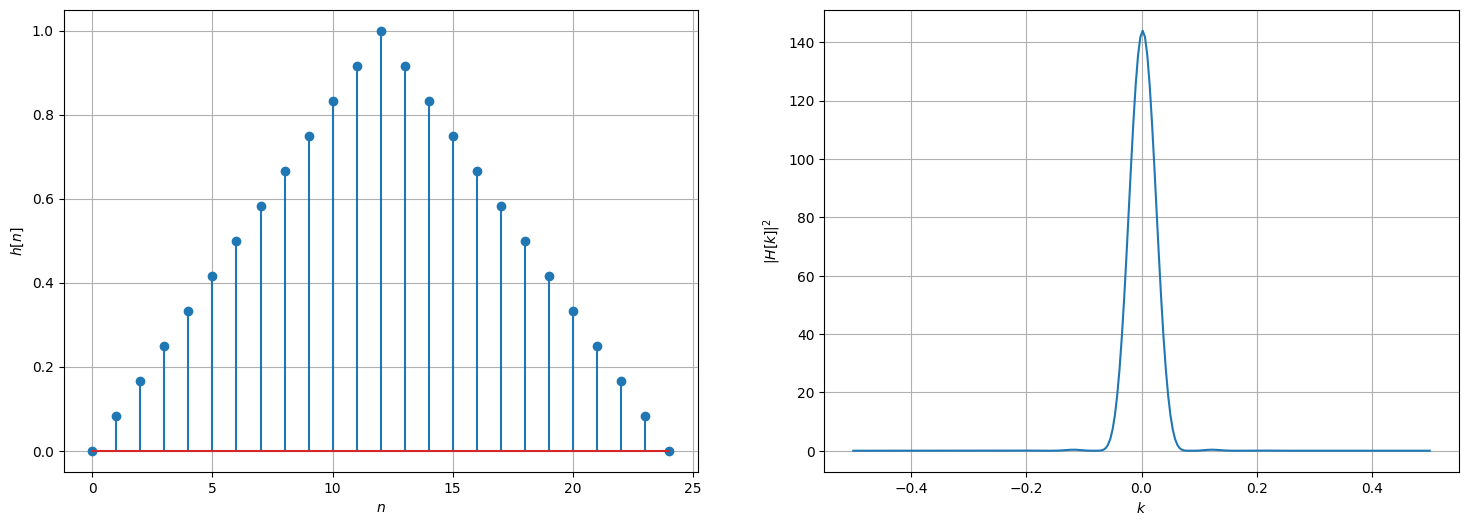

In [4]:
plt.subplot(121)
plt.stem( h )
plt.grid( True )
plt.xlabel('$n$')
plt.ylabel( '$h[n]$')

plt.subplot(122)
plt.plot( f_vector, np.abs( np.fft.fftshift( H ) )**2 )
plt.grid( True )
plt.xlabel('$k$')
plt.ylabel( '$|H[k]|^2$')

### Function for generating mini batch, consisting of a filtered white-noise sequence

In [5]:
def prepare_minibatch( h, EsN0_dB, batch_size ):

    predictor_length = len( h )

    # generate random samples to be filtered
    x = 1 - 2 * np.random.randn( batch_size, predictor_length )
    x_torch = torch.from_numpy( x ).float().to(device)
    
    noise_power = 10**( - EsN0_dB / 10 )
    
    # simulate the actual filter with impulse response h and EsN0
    y = np.zeros( ( batch_size, 1 ) )

    for _n in range( batch_size ):
        y[ _n, ] = np.correlate( x[ _n, : ],  h[ : : -1 ] ) + np.sqrt( noise_power ) * np.random.randn()

    y_torch = torch.from_numpy( y ).float().to(device)

    return x_torch, y_torch

### Class for Prediction

+ Note that the class is very simple, since there is only one layer and one output

In [6]:
class Prediction_network( nn.Module ):
    def __init__(self, input_neurons ):

        super( Prediction_network, self).__init__()
        
        # Linear function, N+1 input neurons (length of filtered sequence)        
        self.fc1 = nn.Linear(input_neurons, 1, bias=False) 

        # Non-linearity
        #self.activation_function = nn.ELU()

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1( x )

        return out

### Learn Model

In [7]:
EsN0_dB = 10

predictor_length = len( h )

model_predict = Prediction_network( predictor_length )
model_predict.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.MSELoss()

# Adam Optimizer
optimizer = optim.Adam( model_predict.parameters() )  

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,1000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        x, y = prepare_minibatch( h, EsN0_dB, batch_size_per_epoch[epoch] )

        outputs = model_predict( x )
        
        # compute loss
        loss = loss_fn( outputs, y)
        
         # compute gradients
        loss.backward()
        
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 18.01029586791992187500000
Epoch 10: Loss 0.10308860242366790771484
Epoch 20: Loss 0.10869697481393814086914
Epoch 30: Loss 0.09233488887548446655273
Epoch 40: Loss 0.08510136604309082031250
Epoch 50: Loss 0.10132651776075363159180
Epoch 60: Loss 0.10356893390417098999023
Epoch 70: Loss 0.09667193144559860229492
Epoch 80: Loss 0.09815340489149093627930
Epoch 90: Loss 0.09559188038110733032227


### Plot Original Impulse Response and Parameters of the Model

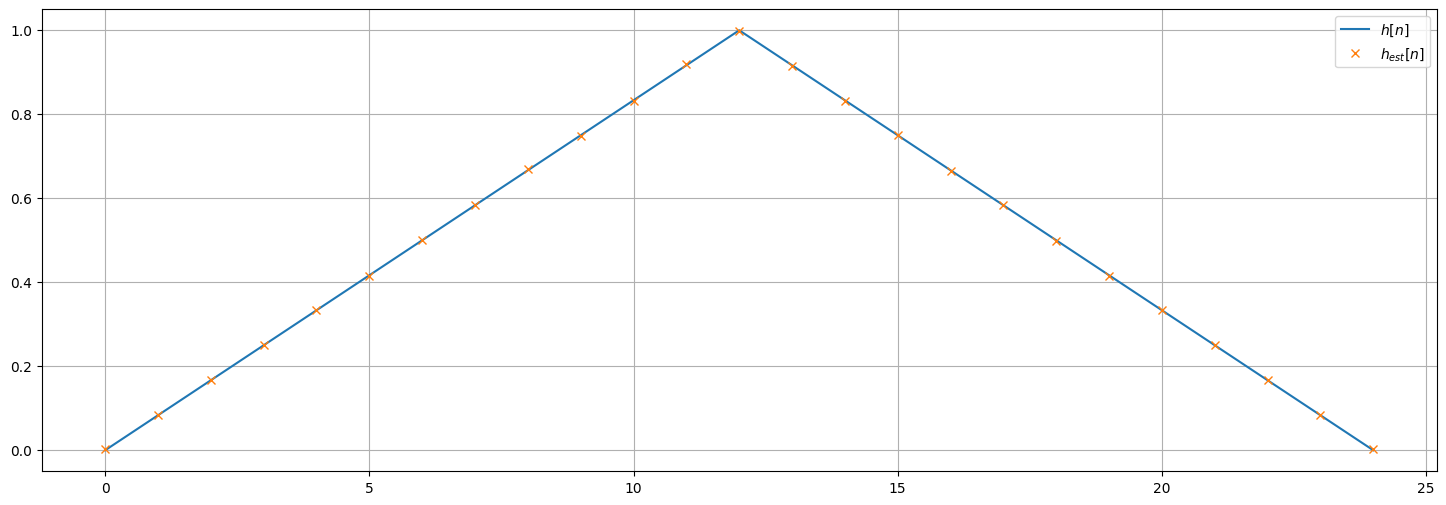

In [8]:
layers = [ p.data for p in model_predict.parameters() ]
h_est = layers[0].numpy()


plt.plot( h, label='$h[n]$' )
plt.plot( h_est.reshape(-1), 'x', label='$h_{est}[n]$' )
#plt.ylim( (-.5, 1.5))
plt.grid( True )
plt.legend()